# setup

In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta, date

In [1]:
from vnstock import Listing, Quote, Company, Finance, Trading, Screener 

/opt/conda/envs/quant/lib/python3.12/site-packages/vnai/scope/profile.py:562: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


# collect data

In [65]:
def get_symbols_by_group(group_name):
    listing = Listing()
    return listing.symbols_by_group(group_name)

def fetch_history_for_symbols(symbols, start='2010-01-01', end='2025-08-25', interval='1D'):
    all_data = []
    for symbol in symbols:
        quote = Quote(symbol=symbol, source='VCI')
        df = quote.history(start=start, end=end, interval=interval)
        df['symbol'] = symbol
        all_data.append(df)
    result = pd.concat(all_data, ignore_index=True)
    result['time'] = pd.to_datetime(result['time'])
    return result

def save_to_csv(df, filepath):
    df.to_csv(filepath, index=False)
    print(f"Đã lưu dữ liệu vào {filepath}")

def filter_data_by_symbol(symbol, start, end, df=data_all):
    df.index = pd.to_datetime(df.index)
    return df[(df['symbol'] == symbol) & (df.index >= start) & (df.index <= end)]

In [ ]:
symbols = get_symbols_by_group('VN30')
result = fetch_history_for_symbols(symbols)
save_to_csv(result, 'data/vn30_history.csv')

Đã lưu dữ liệu vào data/vn30_history.csv


In [57]:
data_all = pd.read_csv('data/vn30_history.csv')
data_all = data_all.set_index('time')
data_all.head()

,open,high,low,close,volume,symbol
time,,,,,,
2010-01-04,3.71,3.97,3.69,3.97,2765900,ACB
2010-01-05,4.06,4.14,3.94,3.97,1929200,ACB
2010-01-06,3.96,4.01,3.86,3.86,1303300,ACB
2010-01-07,3.95,3.97,3.84,3.86,1342000,ACB
2010-01-08,3.87,4.01,3.80,3.83,1461300,ACB


In [43]:
df_hpg = filter_data_by_symbol('HPG')
df_hpg.head()

,open,high,low,close,volume,symbol
time,,,,,,
2010-01-04,1.47,1.49,1.47,1.49,603120,HPG
2010-01-05,1.56,1.56,1.49,1.56,1203080,HPG
2010-01-06,1.55,1.61,1.54,1.61,1771660,HPG
2010-01-07,1.64,1.68,1.61,1.66,1535800,HPG
2010-01-08,1.70,1.70,1.59,1.59,909010,HPG


# MA

In [71]:
def backtest_ma_cross(df, short_window=20, long_window=50, initial_capital=100_000_000, order_size=10_000_000):
    df = df.copy()
    df['MA_short'] = df['close'].rolling(window=short_window).mean()
    df['MA_long'] = df['close'].rolling(window=long_window).mean()
    df['signal'] = 0
    df.loc[df.index[short_window:], 'signal'] = (df['MA_short'][short_window:] > df['MA_long'][short_window:]).astype(int)
    df['position'] = df['signal'].diff()

    capital = initial_capital
    shares = 0
    trades = []
    capital_history = []
    for idx, row in df.iterrows():
        # Buy signal: mua thêm cổ phiếu với số tiền cố định (order_size) nếu còn đủ vốn
        if row['position'] == 1 and capital >= order_size:
            buy_amount = min(order_size, capital)
            buy_shares = buy_amount // row['close']
            if buy_shares > 0:
                capital -= buy_shares * row['close']
                shares += buy_shares
                trades.append((row.name, 'BUY', row['close'], buy_shares, capital))
        # Sell signal: bán toàn bộ cổ phiếu đang giữ
        elif row['position'] == -1 and shares > 0:
            capital += shares * row['close']
            trades.append((row.name, 'SELL', row['close'], shares, capital))
            shares = 0
        # Track capital including current holding value
        total_value = capital + shares * row['close']
        capital_history.append(total_value)
    # Final value if holding shares
    if shares > 0:
        capital += shares * df.iloc[-1]['close']
        trades.append((df.index[-1], 'SELL_END', df.iloc[-1]['close'], shares, capital))
    df = df.iloc[:len(capital_history)]
    df['capital'] = capital_history
    return trades, capital, df

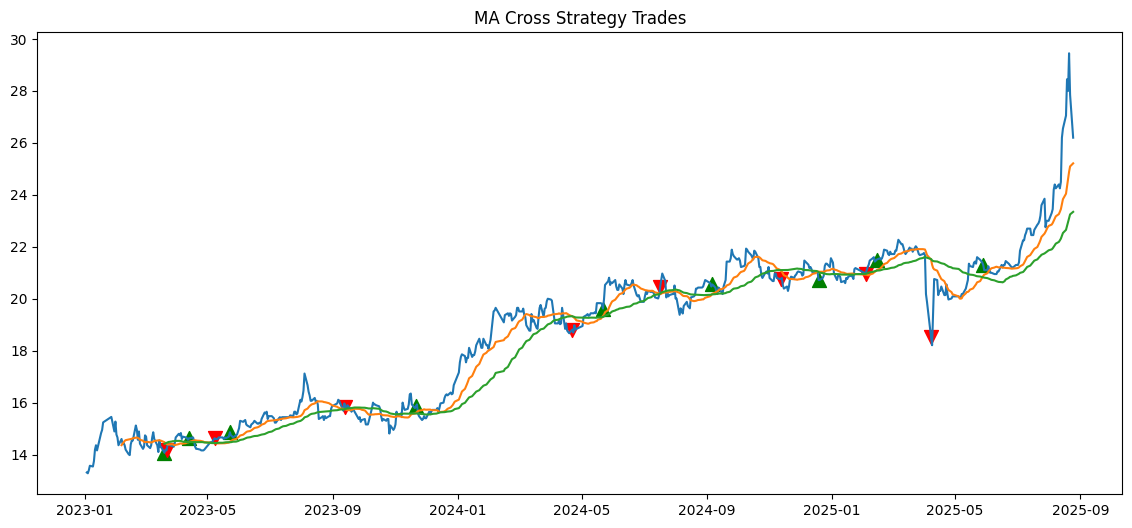

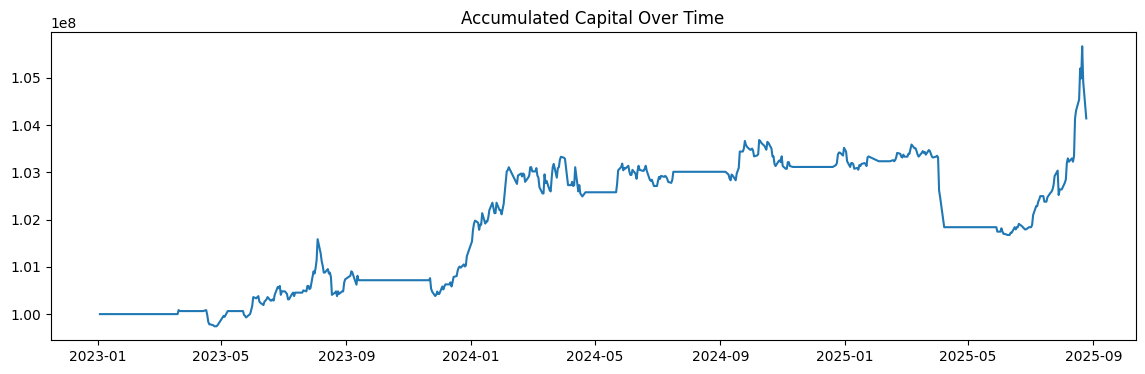

In [72]:

# Example usage for HPG
df_hpg = filter_data_by_symbol('ACB', start='2023-01-01',end='2025-08-25', df=data_all)
trades, final_capital, df_bt = backtest_ma_cross(df_hpg, short_window=20, long_window=50)

# Visualization
plt.figure(figsize=(14,6))
plt.plot(df_bt.index, df_bt['close'], label='Close Price')
plt.plot(df_bt.index, df_bt['MA_short'], label='MA Short')
plt.plot(df_bt.index, df_bt['MA_long'], label='MA Long')
for t in trades:
    if t[1] == 'BUY':
        plt.scatter(t[0], t[2], marker='^', color='g', label='Buy', s=100)
    elif t[1] == 'SELL':
        plt.scatter(t[0], t[2], marker='v', color='r', label='Sell', s=100)
plt.title('MA Cross Strategy Trades')
# hide legend
plt.legend().set_visible(False)
plt.show()

plt.figure(figsize=(14,4))
plt.plot(df_bt.index, df_bt['capital'], label='Accumulated Capital')
plt.title('Accumulated Capital Over Time')
plt.legend().set_visible(False)
plt.show()

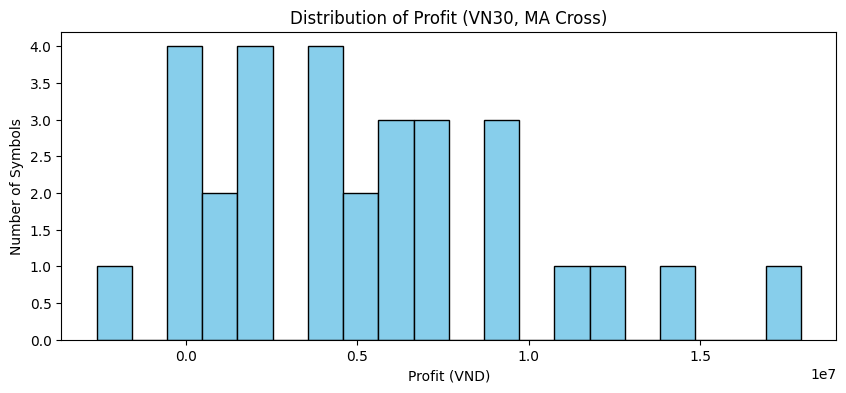

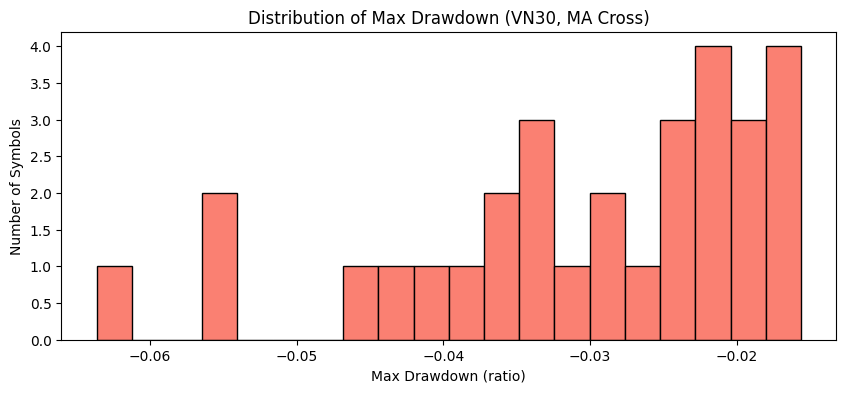

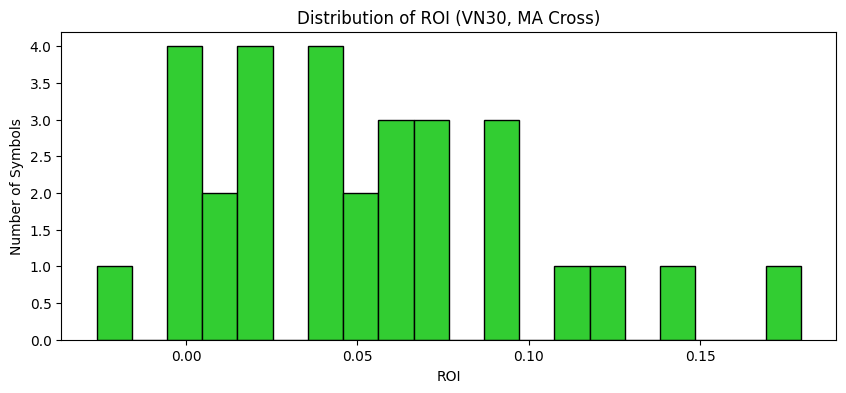

,profit,max_drawdown,roi
count,3.000000e+01,30.000000,30.000000
mean,5.250330e+06,-0.030363,0.052503
std,4.747032e+06,0.012651,0.047470
min,-2.611911e+06,-0.063663,-0.026119
25%,1.861213e+06,-0.036136,0.018612
50%,4.423882e+06,-0.027034,0.044239
75%,7.413578e+06,-0.020627,0.074136
max,1.794379e+07,-0.015611,0.179438


In [74]:
import numpy as np
import matplotlib.pyplot as plt

def calculate_max_drawdown(capital_series):
    roll_max = capital_series.cummax()
    drawdown = (capital_series - roll_max) / roll_max
    return drawdown.min()

symbols = get_symbols_by_group('VN30')
profits = []
drawdowns = []
rois = []
symbols_list = []

for symbol in symbols:
    try:
        df = filter_data_by_symbol(symbol, start='2023-01-01', end='2025-08-25', df=data_all)
        if len(df) < 60:  # skip if not enough data
            continue
        trades, final_capital, df_bt = backtest_ma_cross(df, short_window=20, long_window=50)
        profit = final_capital - 100_000_000
        max_dd = calculate_max_drawdown(df_bt['capital'])
        roi = profit / 100_000_000
        profits.append(profit)
        drawdowns.append(max_dd)
        rois.append(roi)
        symbols_list.append(symbol)
    except Exception as e:
        print(f"{symbol}: {e}")

# Plot profit distribution
plt.figure(figsize=(10,4))
plt.hist(profits, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Profit (VN30, MA Cross)')
plt.xlabel('Profit (VND)')
plt.ylabel('Number of Symbols')
plt.show()

# Plot max drawdown distribution
plt.figure(figsize=(10,4))
plt.hist(drawdowns, bins=20, color='salmon', edgecolor='black')
plt.title('Distribution of Max Drawdown (VN30, MA Cross)')
plt.xlabel('Max Drawdown (ratio)')
plt.ylabel('Number of Symbols')
plt.show()

# Plot ROI distribution
plt.figure(figsize=(10,4))
plt.hist(rois, bins=20, color='limegreen', edgecolor='black')
plt.title('Distribution of ROI (VN30, MA Cross)')
plt.xlabel('ROI')
plt.ylabel('Number of Symbols')
plt.show()

# Optional: Show summary statistics
import pandas as pd
summary = pd.DataFrame({
    'symbol': symbols_list,
    'profit': profits,
    'max_drawdown': drawdowns,
    'roi': rois
})
display(summary.describe())